In [1]:
import sys
sys.path.append('../../train/')

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib.pyplot import rc_context

from util import array2mat

In [2]:
map_info = pd.read_csv('/lmh_data/data/sclab/sclab/map_result.csv', sep='\t', index_col=0)
rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})

eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/PDGFRA/evaluate.npy', allow_pickle=True)

In [3]:
rna = rna[map_info.index]
rna = rna[rna.obs['cell_type'].isin(['OPC', 'ODC']),:]
rna.layers["counts"] = rna.X.copy()

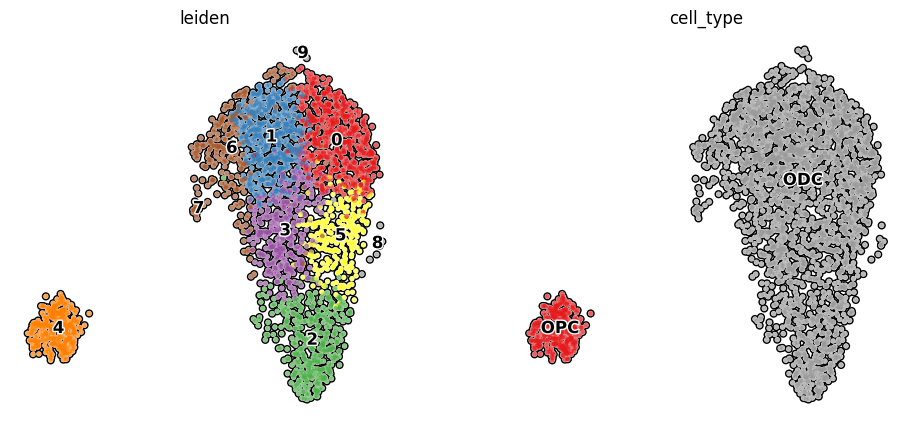

In [4]:
rna.X = rna.layers["counts"].copy()
sc.pp.highly_variable_genes(rna, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)
sc.pp.scale(rna)
sc.tl.pca(rna, n_comps=100, svd_solver="auto")

sc.pp.neighbors(rna, metric="cosine")
sc.tl.umap(rna)
sc.tl.leiden(rna)

with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(rna, color=['leiden', 'cell_type'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2, frameon=False, palette='Set1')

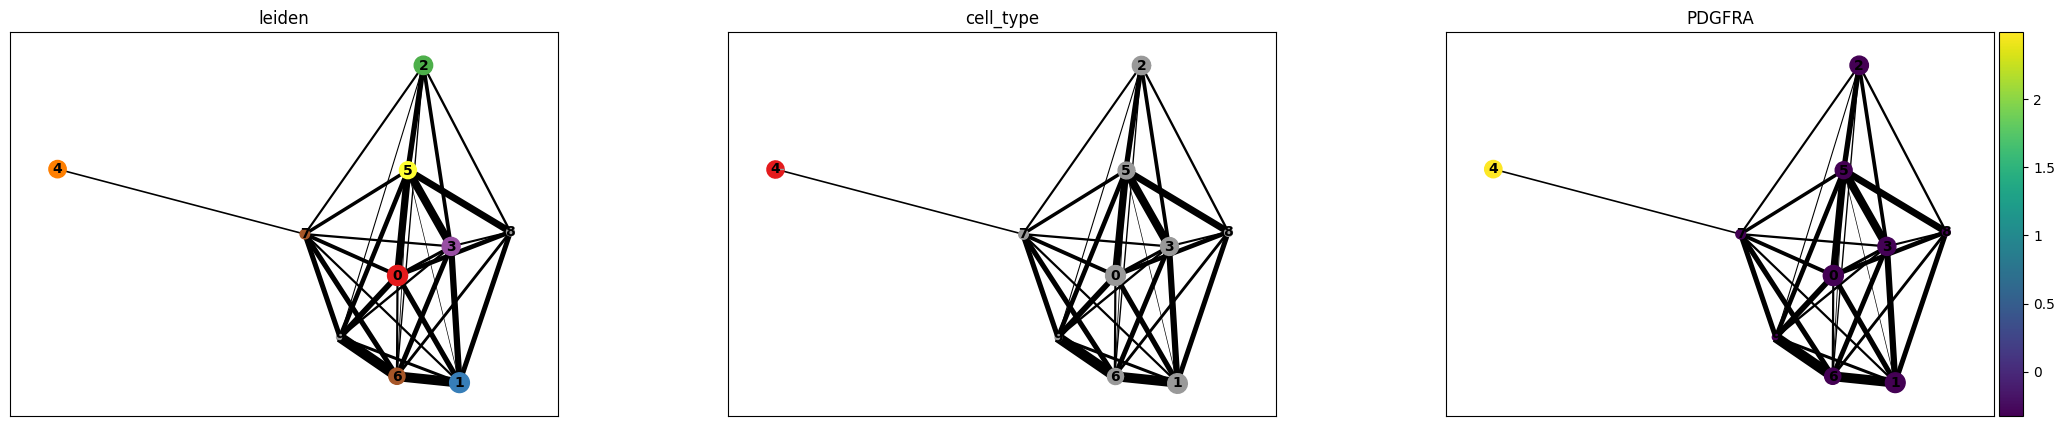

In [5]:
sc.tl.paga(rna, groups='leiden')
sc.pl.paga(rna, color=['leiden', 'cell_type', 'PDGFRA'])

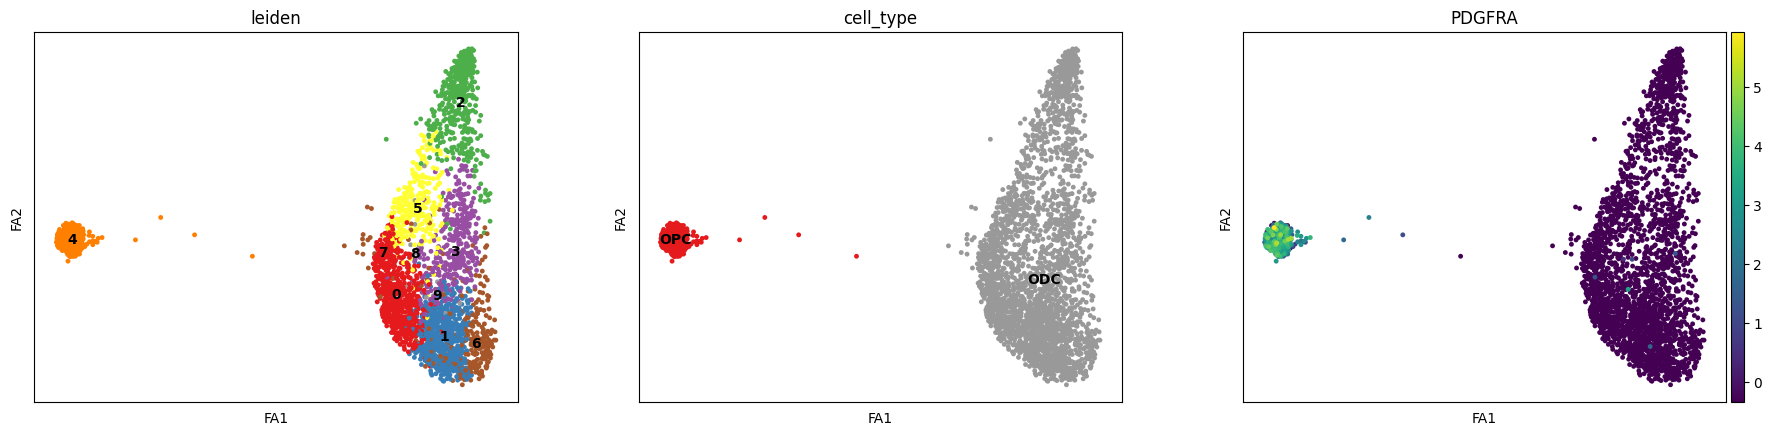

In [6]:
sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', 'PDGFRA'], legend_loc='on data')

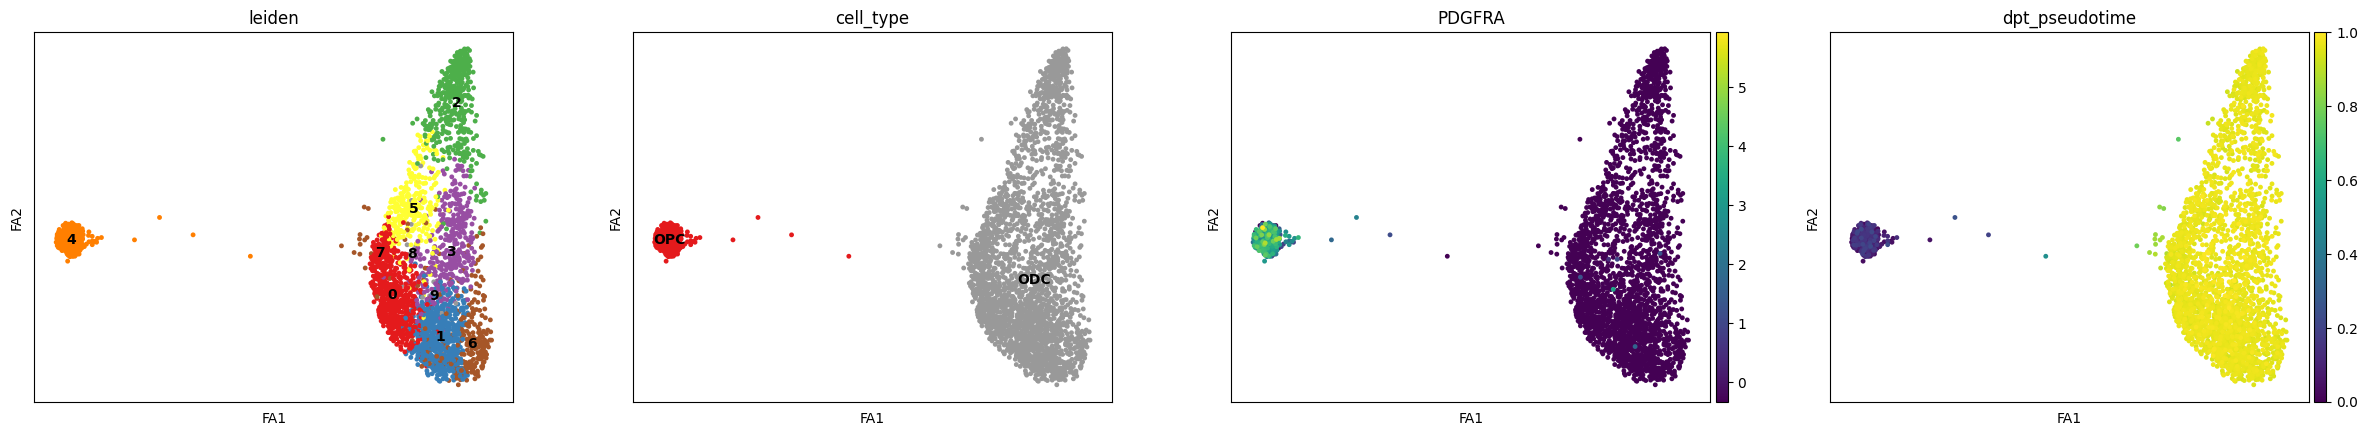

In [7]:
rna.uns['iroot'] = np.flatnonzero(rna.obs['leiden']=='4')[0]
sc.tl.dpt(rna)

sc.tl.draw_graph(rna, init_pos='paga')
sc.pl.draw_graph(rna, color=['leiden', 'cell_type', 'PDGFRA', 'dpt_pseudotime'], legend_loc='on data')

In [8]:
rna.obs.groupby('leiden').dpt_pseudotime.mean()

leiden
0    0.961446
1    0.963174
2    0.960857
3    0.965784
4    0.085270
5    0.965022
6    0.961691
7    0.903234
8    0.987009
9    0.988259
Name: dpt_pseudotime, dtype: float32

In [9]:
scHiC = {}
_rna = rna[:, eval_set[0]['scRNA_head']]
_rna_counts = _rna.layers["counts"].astype(np.int32)
for i in range(len(preds)):
    if eval_set[i]['identity'] == 'fake':
        continue
    if eval_set[i]['cell_type'] not in ['OPC', 'ODC']:
        continue
    for j in range(_rna.shape[0]):
        if (_rna_counts[j] == eval_set[i]['scRNA']).all():
            scHiC[_rna[j].obs_names[0]] = preds[i]['predict']
            break
scHiC

{'CTAAGTGGTGTCCAAT-LKTX_190130_01_F01': array([ 7.1765715e-01,  7.7962377e-03, -1.5292611e-02,  3.7247669e-03,
         4.9920008e-03,  1.3692630e-02, -8.0058295e-03, -5.9175342e-03,
         5.4039180e-01,  1.6052878e-02,  2.7922731e-02,  9.9876411e-03,
        -9.7597763e-03,  1.3279343e-02, -4.5892820e-03,  2.5895616e-01,
         1.6836289e-02, -4.2700740e-03, -7.6338369e-03, -1.3889222e-03,
         8.4734354e-03,  5.5307990e-01,  2.6273727e-04,  4.0741055e-03,
        -1.8506175e-02,  1.1477955e-02,  5.1618022e-01,  2.3531817e-02,
         1.9906452e-02,  7.0858207e-03,  5.6626999e-01,  5.9433326e-02,
         2.6235022e-03,  5.8706230e-01, -2.8943010e-03,  5.9684032e-01],
       dtype=float32),
 'GATGAGGCAGTCGGTC-LKTX_190130_01_H01': array([ 0.42750403  , -0.0032991725, -0.020345028 ,  0.015110103 ,
         0.008269269 ,  0.008378537 , -0.004043241 , -0.015596382 ,
         0.33025488  , -0.007042093 ,  0.027558584 ,  0.014924008 ,
        -0.00973486  ,  0.026146527 ,  0.01038

In [10]:
hics = []
for rna_name in rna.obs.sort_values(by='dpt_pseudotime').index:
    if rna_name not in scHiC.keys():
        continue
    hics.append(scHiC[rna_name])
    
i_range, j_range = 5, int(len(hics)/5)
_hics = {0: None, 1: None, 2: None, 3: None, 4: None}
for i in range(i_range):
    for j in range(j_range):
        _hic = hics[i*j_range+j]
        _hic += abs(_hic.min())
        if _hics[i] is not None:
            _hics[i] += _hic
        else:
            _hics[i] = _hic
    _hics[i] = array2mat(_hics[i]/j_range)

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def colorbar_triangle(axm,im,ymax):
    height="2%"
    width="10%"
    if ymax!=None:
        height="6%"
    axins1 = inset_axes(axm, width=width, height=height, loc=4, bbox_to_anchor=(-0.1, 0.7, 1.2, 2.9), bbox_transform=axm.transAxes,)
    cbar=plt.colorbar(im, cax=axins1, orientation='horizontal')
    cbar.ax.xaxis.tick_top()
    cbar.ax.spines['top'].set_color('none')
    cbar.ax.spines['right'].set_color('none')
    cbar.ax.spines['bottom'].set_color('none')
    cbar.ax.spines['left'].set_color('none')


def heatmap_triangle(
    axes, mat, matBalance=False,
    width=6, height=3, cmap=mpl.cm.YlGnBu, showXticks=True, title=None, ymax=None, logData=False, vmax=None
):
    if logData == True:
        mat = np.log2(mat)

    N = mat.shape[1]

    # Transformation matrix for rotating the heatmap.
    A = np.array([(y, x) for x in range(N, -1, -1) for y in range(N + 1)])
    t = np.array([[1,0.5], [-1,0.5]])
    A = np.dot(A, t)

    C = np.triu(mat)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    #axes.set_xticks([])
    axes.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(N + 1, N + 1)
    Y = A[:, 0].reshape(N + 1, N + 1)

    #caxes = pl.pcolormesh(X, Y, np.fliplr(C), axes=axes, cmap=cmap, norm=norm)

    #norm=MidpointNormalize(midpoint=0,vmin=-1, vmax=1)
    vmax = vmax if vmax else mat.max()
    caxes = axes.pcolormesh(
        X, Y, np.flipud(C), axes=axes, cmap=cmap, edgecolor='none', snap=True, linewidth=.001, vmax=vmax)
    #caxes = axes.matshow(np.flipud(C), cmap=cmap, norm=norm)

    # Remove the ticks and reset the x limit.

    axes.set_ylim(bottom=0)
    axes.set_xlim(left=0)
    if ymax != None:
        axes.set_ylim(top=ymax)
    axes.set_title(title)
    
    #set_heatmap_ticks(axes)
    
    axes.axis("off")
    colorbar_triangle(axes, caxes, ymax)
    
def plot_diag(ax, diag, ylabel, resolution=10000, yminx=5, ymaxx=95, rotation=0, fl='%0.2f', color='#464451'):
    ax.tick_params(bottom=False, top=False, left=True, right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = len(diag)

    width = 1
    ax.bar(x=range(0,x), height=diag, width=1, bottom=[0]*(x), color=color, align="edge", edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(diag, yminx)
    ymax = np.percentile(diag, ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')

In [12]:
def pre_track(predict_mat, vmax):
    fig = plt.figure(figsize=(14, 9), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(14, 1)
    ax0 = fig.add_subplot(gs[0:8, 0], facecolor='white')

    _test = predict_mat
    row, col = np.diag_indices_from(_test)
    _diag = _test[row,col].copy()
    
    _test[row,col] = 0
    heatmap_triangle(ax0, _test, width=6, height=2.7, logData=False, vmax=vmax)

    plt.show()

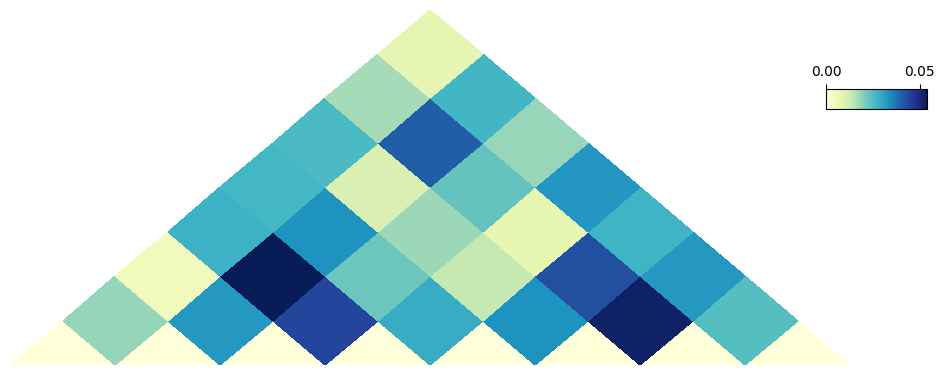

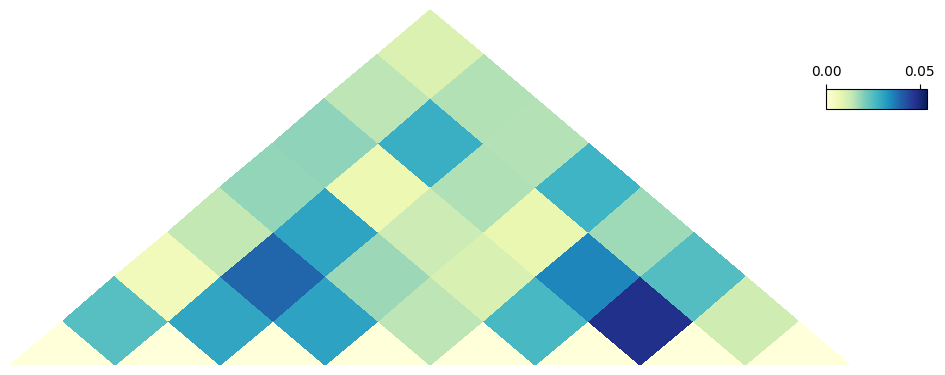

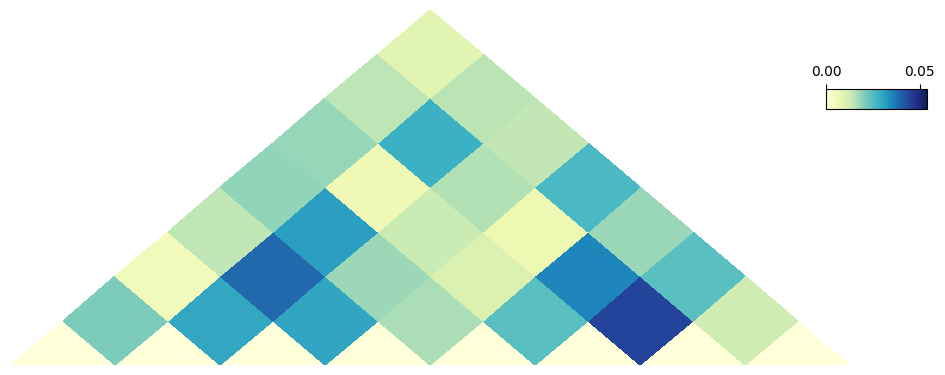

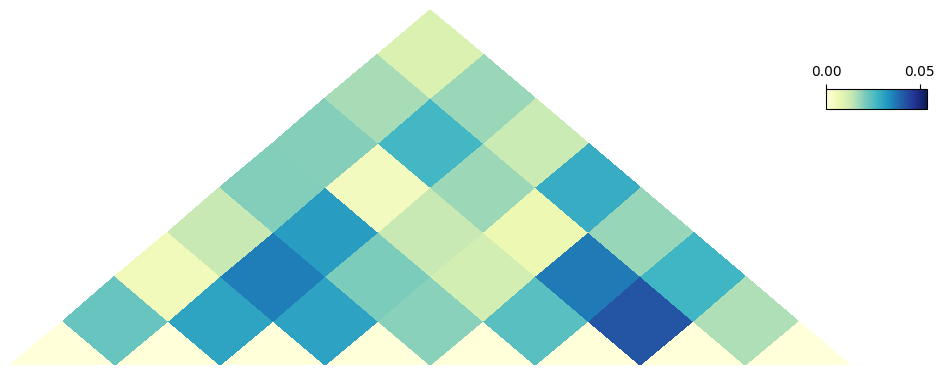

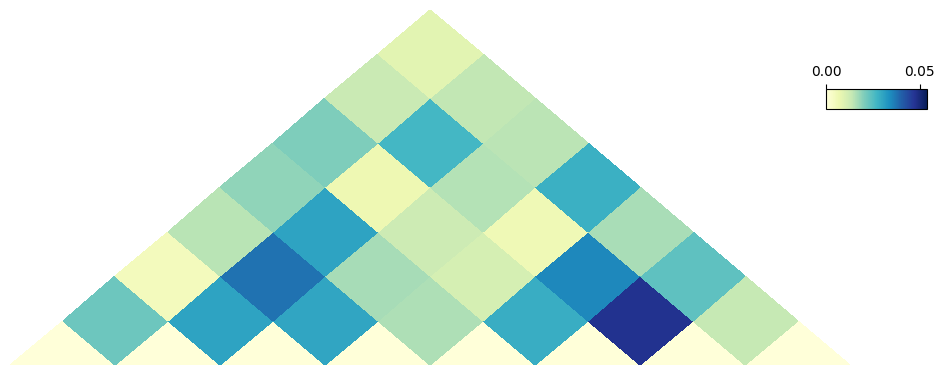

In [13]:
vmax = 0
for i in range(5):
    vmax = max(vmax, np.triu(_hics[i], 1).max())
pre_track(_hics[0], vmax)
pre_track(_hics[1], vmax)
pre_track(_hics[2], vmax)
pre_track(_hics[3], vmax)
pre_track(_hics[4], vmax)